this part creates new features and prepares data for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import pickle
import timeit
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
# self-defined function
from func import get_FDR

plt.style.use('seaborn-v0_8-deep') 

In [2]:
# Load the dataset
df = pd.read_csv('./data/cleaned.csv', index_col=0)
print(f"Dataset loaded: {df.shape}")

df['date'] = pd.to_datetime(df['date'])
df.zip5 = df.zip5.astype(str).str.zfill(5)
df.ssn = df.ssn.astype(str)
df.dob = df.dob.astype(str)
df.homephone = df.homephone.astype(str)

print(f"\nDataset info:")
df.info()

Dataset loaded: (981694, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 981694 entries, 0 to 981693
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         981694 non-null  datetime64[ns]
 1   ssn          981694 non-null  object        
 2   firstname    981694 non-null  object        
 3   lastname     981694 non-null  object        
 4   address      981694 non-null  object        
 5   zip5         981694 non-null  object        
 6   dob          981694 non-null  object        
 7   homephone    981694 non-null  object        
 8   fraud_label  981694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 74.9+ MB


# Dimension Expand

In [3]:
# Extract time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
#df['dow'] = df['date'].dt.dayofweek
df['dow'] = df['date'].dt.day_name()

### Risk table for day of week
by sigmoid-based smoothing

In [4]:
train_test = df[df.date < '2016-11-01']

In [5]:
# do statistical smoothing
c = 4
nmid = 20
y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

In [6]:
df[['year', 'month', 'day', 'dow', 'dow_risk', 'fraud_label']].sample(5)

,year,month,day,dow,dow_risk,fraud_label
288476,2016,4,18,Monday,0.013641,0
841106,2016,11,9,Wednesday,0.015339,0
712851,2016,9,22,Thursday,0.015111,0
119414,2016,2,14,Sunday,0.013860,0
127610,2016,2,17,Wednesday,0.015339,0


### Create entitties

In [7]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladdress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone
df['homephone_name_dob'] = df.homephone + df.name_dob

In [8]:
for field in df.select_dtypes(include=['object', 'category']).columns:
    df['ssn_' + field] = df.ssn + df[field]
attributes = df.select_dtypes(include=['object', 'category']).columns
print(attributes)

Index(['ssn', 'firstname', 'lastname', 'address', 'zip5', 'dob', 'homephone',
       'dow', 'name', 'fulladdress', 'name_dob', 'name_fulladdress',
       'name_homephone', 'fulladdress_dob', 'fulladdress_homephone',
       'dob_homephone', 'homephone_name_dob', 'ssn_ssn', 'ssn_firstname',
       'ssn_lastname', 'ssn_address', 'ssn_zip5', 'ssn_dob', 'ssn_homephone',
       'ssn_dow', 'ssn_name', 'ssn_fulladdress', 'ssn_name_dob',
       'ssn_name_fulladdress', 'ssn_name_homephone', 'ssn_fulladdress_dob',
       'ssn_fulladdress_homephone', 'ssn_dob_homephone',
       'ssn_homephone_name_dob'],
      dtype='object')


### Velocity + Day since

In [ ]:
# previous:
# start = timeit.default_timer()

# for entity in attributes:
    
#     try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
#     except: print('\n')
#     st = timeit.default_timer()
    
#     df_l = df1[['record', 'date', entity]]
#     df_r = df1[['check_record', 'check_date', entity]]
    
#     temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    
#     temp1 = temp[temp.record > temp.check_record][['record','date','check_date']]\
#                                                 .groupby('record')[['date', 'check_date']].last()
#     mapper = (temp1.date - temp1.check_date).dt.days
#     final[entity + '_day_since'] = final.record.map(mapper)
#     final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2016-01-01')).dt.days, inplace = True)

#     print('\n' + entity + '_day_since ---> Done')
    
#     for time in [0,1,3,7,14,30]:
        
#         temp_1 = temp[(temp.check_date >= (temp.date - dt.timedelta(time))) &\
#                        (temp.record >= temp.check_record)]
        
#         col_name = entity + '_count_' + str(time)    
#         mapper2 = temp_1.groupby('record')[entity].count()      
#         final[col_name] = final.record.map(mapper2)
        
#         print(entity + '_count_' + str(time) + ' ---> Done')

# print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Run time for the last entity ----------------- 17.981693499954417s

ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for the last entity ----------------- 1.1341381249949336s


In [9]:
df1 = df.copy()
df1['record'] = list(df1.index)
final = df.copy()
final['record'] = list(final.index)
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [12]:
import timeit
import datetime as dt
from typing import Dict, List
import gc

on a million-record dataset, the previous code is not efficient, to optimize, can apply:
1. Optimize Data Types  
Reduce memory footprint before processing  

In [ ]:
def optimize_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """Optimize DataFrame data types to reduce memory usage."""
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    return df

2. Process in Chunks  
Instead of merging the entire dataset, process in smaller chunks/ pieces
3. Use Iterator-based Merge   
For very large datasets, use chunksize parameter in merge operations
4. Garbage collection  
Explicitly free memory after each step
5. Avoid duplicating data  
Process and immediately aggregate

In [ ]:
def process_entity_chunked(df1: pd.DataFrame, entity: str, final: pd.DataFrame, 
                          chunk_size: int = 50000) -> pd.DataFrame:
    """Process entity with chunking to reduce memory usage."""
    
    print(f"\nProcessing {entity}...")
    st = timeit.default_timer()
    
    # Sort data once for efficiency
    df1_sorted = df1.sort_values('record')
    
    # Process day_since in chunks
    day_since_results = {}
    
    for start_idx in range(0, len(df1_sorted), chunk_size):
        end_idx = min(start_idx + chunk_size, len(df1_sorted))
        chunk_records = df1_sorted.iloc[start_idx:end_idx]['record'].unique()
        
        # Get relevant data for this chunk
        chunk_data = df1[df1['record'].isin(chunk_records) | 
                        df1['check_record'].isin(chunk_records)]
        
        # Self-join on entity
        df_l = chunk_data[['record', 'date', entity]]
        df_r = chunk_data[['check_record', 'check_date', entity]]
        
        temp = pd.merge(df_l, df_r, on=entity, suffixes=('', '_r'))
        temp = temp[temp.record > temp.check_record]
        
        if len(temp) > 0:
            # Calculate days since
            temp1 = temp[['record', 'date', 'check_date']].groupby('record').last()
            days_diff = (temp1['date'] - temp1['check_date']).dt.days
            
            for record, days in days_diff.items():
                day_since_results[record] = days
        
        # Clean up
        del temp, df_l, df_r
        gc.collect()
    
    # Map results
    final[entity + '_day_since'] = final['record'].map(day_since_results)
    final[entity + '_day_since'].fillna(
        (final['date'] - pd.to_datetime('2016-01-01')).dt.days, 
        inplace=True
    )
    
    print(f'{entity}_day_since ---> Done')
    
    # Process counts for different time windows
    for time_window in [0, 1, 3, 7, 14, 30]:
        count_results = {}
        
        for start_idx in range(0, len(df1_sorted), chunk_size):
            end_idx = min(start_idx + chunk_size, len(df1_sorted))
            chunk_records = df1_sorted.iloc[start_idx:end_idx]['record'].unique()
            
            # Get relevant data
            chunk_data = df1[df1['record'].isin(chunk_records) | 
                            df1['check_record'].isin(chunk_records)]
            
            # Self-join
            df_l = chunk_data[['record', 'date', entity]]
            df_r = chunk_data[['check_record', 'check_date', entity]]
            
            temp = pd.merge(df_l, df_r, on=entity, suffixes=('', '_r'))
            
            # Filter by time window
            temp_filtered = temp[
                (temp['check_date'] >= (temp['date'] - pd.Timedelta(days=time_window))) &
                (temp['record'] >= temp['check_record'])
            ]
            
            if len(temp_filtered) > 0:
                counts = temp_filtered.groupby('record')[entity].count()
                for record, count in counts.items():
                    count_results[record] = count
            
            # Clean up
            del temp, temp_filtered, df_l, df_r
            gc.collect()
        
        # Map results
        col_name = f'{entity}_count_{time_window}'
        final[col_name] = final['record'].map(count_results).fillna(0).astype('int32')
        
        print(f'{col_name} ---> Done')
    
    print(f'Entity {entity} completed in {(timeit.default_timer() - st):.2f}s')
    return final

In [ ]:
def process_all_entities(df1: pd.DataFrame, attributes: List[str], 
                        final: pd.DataFrame, chunk_size: int = 50000) -> pd.DataFrame:
    """Process all entities with memory optimization."""
    
    start = timeit.default_timer()
    
    # Optimize data types first
    print("Optimizing data types...")
    df1 = optimize_dtypes(df1)
    
    # Ensure date columns are datetime
    df1['date'] = pd.to_datetime(df1['date'])
    df1['check_date'] = pd.to_datetime(df1['check_date'])
    
    # Process each entity
    for entity in attributes:
        final = process_entity_chunked(df1, entity, final, chunk_size)
        
        # Force garbage collection after each entity
        gc.collect()
    
    print(f'\nTotal run time: {(timeit.default_timer() - start)/60:.2f} mins')
    return final

6. SQL-based Approach with DuckDB  
For large self-joins, DuckDB is much more memory-efficient

In [ ]:
def process_with_duckdb(df1: pd.DataFrame, attributes: List[str], 
                       final: pd.DataFrame) -> pd.DataFrame:
    """Process using DuckDB for better memory efficiency."""
    
    import duckdb
    
    start = timeit.default_timer()
    conn = duckdb.connect(':memory:')
    
    # Register DataFrame
    conn.register('df1', df1)
    conn.register('final', final)
    
    for entity in attributes:
        st = timeit.default_timer()
        
        # Calculate day_since using SQL
        query_day_since = f"""
        WITH last_records AS (
            SELECT 
                l.record,
                MAX(l.date - r.check_date) as days_diff
            FROM df1 l
            JOIN df1 r ON l.{entity} = r.{entity}
            WHERE l.record > r.check_record
            GROUP BY l.record
        )
        SELECT * FROM last_records
        """
        
        day_since_df = conn.execute(query_day_since).df()
        
        # Process each time window
        for time_window in [0, 1, 3, 7, 14, 30]:
            query_count = f"""
            SELECT 
                l.record,
                COUNT(*) as count
            FROM df1 l
            JOIN df1 r ON l.{entity} = r.{entity}
            WHERE l.record >= r.check_record
                AND r.check_date >= l.date - INTERVAL '{time_window} days'
            GROUP BY l.record
            """
            
            count_df = conn.execute(query_count).df()
            col_name = f'{entity}_count_{time_window}'
            final = final.merge(count_df, on='record', how='left')
            final.rename(columns={'count': col_name}, inplace=True)
            final[col_name].fillna(0, inplace=True)
        
        print(f'Entity {entity} completed in {(timeit.default_timer() - st):.2f}s')
    
    conn.close()
    print(f'\nTotal run time: {(timeit.default_timer() - start)/60:.2f} mins')
    return final

In [11]:
# final = process_all_entities(df1, attributes, final, chunk_size=25000)
# or for very large datasets:
final = process_with_duckdb(df1, attributes, final)

Entity ssn completed in 2.99s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entity firstname completed in 20.43s
Entity lastname completed in 9.80s
Entity address completed in 3.10s
Entity zip5 completed in 5.73s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entity dob completed in 90.28s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entity homephone completed in 37.07s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entity dow completed in 816.35s
Entity name completed in 4.04s
Entity fulladdress completed in 3.89s
Entity name_dob completed in 4.41s
Entity name_fulladdress completed in 4.70s
Entity name_homephone completed in 4.99s
Entity fulladdress_dob completed in 6.13s
Entity fulladdress_homephone completed in 5.93s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Entity dob_homephone completed in 16.99s
Entity homephone_name_dob completed in 6.64s
Entity ssn_ssn completed in 8.29s
Entity ssn_firstname completed in 7.64s
Entity ssn_lastname completed in 8.50s
Entity ssn_address completed in 9.57s
Entity ssn_zip5 completed in 10.26s
Entity ssn_dob completed in 9.22s
Entity ssn_homephone completed in 10.83s
Entity ssn_dow completed in 11.14s
Entity ssn_name completed in 12.22s
Entity ssn_fulladdress completed in 13.70s
Entity ssn_name_dob completed in 14.42s
Entity ssn_name_fulladdress completed in 15.43s
Entity ssn_name_homephone completed in 15.14s
Entity ssn_fulladdress_dob completed in 15.07s
Entity ssn_fulladdress_homephone completed in 15.22s
Entity ssn_dob_homephone completed in 15.73s
Entity ssn_homephone_name_dob completed in 17.49s

Total run time: 20.89 mins


### Relative Velocity

- calculate rate ratios or normalized counts for different time windows  
- count_in_X_days / (count_in_Y_days / Y)  
- which gives us: How many times higher is X's count compared to the average daily count over the last Y days  
- is commonly used in Fraud detection where sudden spikes in activity (high ratio) happened

In [13]:
for att in attributes:
    for d in ['0', '1']:
        for dd in ['3', '7', '14', '30']:
            final[att + '_count_' + d + '_by_' + dd] =\
            final[att + '_count_' + d]/(final[att + '_count_' + dd]/float(dd))

## DOB and Age

In [18]:
final['dob'].sample(5)

151358    19800629
132501    19841003
451252    20001101
241643    19410607
615067    19700418
Name: dob, dtype: object

In [19]:
final['birth_year'] = final['dob'].str[:4].astype(int)
final['birth_month'] = final['dob'].str[4:6].astype(int)
final['birth_day'] = final['dob'].str[6:8].astype(int)

# Calculate age at transaction
final['age'] = (final['date'].dt.year - final['birth_year']) + \
                               ((final['date'].dt.month - final['birth_month']) / 12)

### Keep desired variables

In [22]:
# only keep the numerical variables
final_cut = final.copy()
for field in final_cut.select_dtypes(include=['object', 'category']).columns:
    final_cut.drop(field, inplace=True, axis=1)

In [28]:
final_cut.drop(['date','record'], axis=1, inplace = True)

In [29]:
final_cut.columns.to_list()

['fraud_label',
 'year',
 'month',
 'day',
 'dow_risk',
 'ssn_count_0',
 'ssn_count_1',
 'ssn_count_3',
 'ssn_count_7',
 'ssn_count_14',
 'ssn_count_30',
 'firstname_count_0',
 'firstname_count_1',
 'firstname_count_3',
 'firstname_count_7',
 'firstname_count_14',
 'firstname_count_30',
 'lastname_count_0',
 'lastname_count_1',
 'lastname_count_3',
 'lastname_count_7',
 'lastname_count_14',
 'lastname_count_30',
 'address_count_0',
 'address_count_1',
 'address_count_3',
 'address_count_7',
 'address_count_14',
 'address_count_30',
 'zip5_count_0',
 'zip5_count_1',
 'zip5_count_3',
 'zip5_count_7',
 'zip5_count_14',
 'zip5_count_30',
 'dob_count_0',
 'dob_count_1',
 'dob_count_3',
 'dob_count_7',
 'dob_count_14',
 'dob_count_30',
 'homephone_count_0',
 'homephone_count_1',
 'homephone_count_3',
 'homephone_count_7',
 'homephone_count_14',
 'homephone_count_30',
 'dow_count_0',
 'dow_count_1',
 'dow_count_3',
 'dow_count_7',
 'dow_count_14',
 'dow_count_30',
 'name_count_0',
 'name_coun

In [30]:
final_cut.shape

(981694, 485)

In [32]:
final_cut.sample(5)

,fraud_label,year,month,day,dow_risk,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,...,ssn_homephone_name_dob_count_0_by_14,ssn_homephone_name_dob_count_0_by_30,ssn_homephone_name_dob_count_1_by_3,ssn_homephone_name_dob_count_1_by_7,ssn_homephone_name_dob_count_1_by_14,ssn_homephone_name_dob_count_1_by_30,birth_year,birth_month,birth_day,age
663247,0,2016,9,4,0.013860,1,1,1,1,1,...,14.0,30.0,3.0,7.0,14.0,30.0,1907,6,26,109.250000
663901,0,2016,9,4,0.013860,1,1,1,1,1,...,14.0,30.0,3.0,7.0,14.0,30.0,1963,4,23,53.416667
433918,0,2016,6,10,0.014702,1,1,1,1,1,...,14.0,30.0,3.0,7.0,14.0,30.0,2003,4,22,13.166667
386577,0,2016,5,24,0.014220,1,1,1,1,1,...,14.0,30.0,3.0,7.0,14.0,30.0,1918,12,19,97.416667
863720,0,2016,11,18,0.014702,1,1,1,1,1,...,14.0,30.0,3.0,7.0,14.0,30.0,1916,9,23,100.166667


In [33]:
final_cut.to_csv('./data/vars 485.csv')

# Feature Selection

In [2]:
final_cut = pd.read_csv('./data/vars 485.csv', index_col=0)
data = final_cut.loc[(final_cut.index <= 790000)&(final_cut.index >= 35755)]
data['RANDOM'] = np.random.ranf(len(data))
del final_cut

## Filter

In [3]:
from scipy.stats import ks_2samp
from sklearn.feature_selection import SelectKBest

The **ks_2samp()** function computes the Kolmogorov–Smirnov (KS) statistic, which measures the maximum distance between the cumulative distribution functions (CDFs) of two groups (fraud vs. non-fraud) for a given feature
- KS value ranges from 0 to 1.
Higher KS means better separation → the feature is more discriminatory
- To measure how well a feature distinguishes between frauds (fraud_label = 1) and non-frauds (fraud_label = 0)

In [4]:
num_vars = data.shape[1]
goods = data[data['fraud_label'] == 0]
bads = data[data['fraud_label'] == 1]
results = {}
for col in data.columns:
    if col != 'fraud_label':
        try:
            results[col] = ks_2samp(goods[col],bads[col])[0]
        except Exception as e:
            print(f"Could not process column {col}: {e}")
filter_df = pd.DataFrame([results]).T.reset_index()
filter_df.columns = ['feature', 'KS']
filter_df.sort_values(by=['KS'], ascending = False, inplace = True)
filter_df.head(10)

,feature,KS
27,address_count_30,0.329452
63,fulladdress_count_30,0.328546
26,address_count_14,0.318845
62,fulladdress_count_14,0.318109
25,address_count_7,0.297637
61,fulladdress_count_7,0.297425
235,address_count_0_by_30,0.287879
283,fulladdress_count_0_by_30,0.287071
234,address_count_0_by_14,0.277491
282,fulladdress_count_0_by_14,0.276820


In [5]:
del goods, bads

**Fraud Detection Rate (FDR)**: Take the top 3% and bottom 3% values of each feature. Compute the fraud rate (i.e., proportion of frauds) in both subsets. then keep the maximum FDR between the two tails.
- Higher FDR means fraud cases are concentrated in the extreme values of the feature. Indicates the feature is useful for detecting fraud in high- or low-end values.
- Measures how concentrated the frauds are at the extremes of each feature.

In [6]:
KSFDR = pd.merge(filter_df, get_FDR(data), on='feature') 

In [7]:
KSFDR['rank_ks'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)
KSFDR['avg_rank'] = (KSFDR['rank_ks']+KSFDR['rank_FDR'])/2
KSFDR.sort_values(by=['avg_rank'], ascending = False, inplace = True)

In [8]:
KSFDR.reset_index(drop=True)
num_keep = 70
cols_keep = list(KSFDR['feature'][1:num_keep])
cols_keep

['fulladdress_count_30',
 'address_count_14',
 'fulladdress_count_14',
 'address_count_7',
 'fulladdress_count_7',
 'address_count_0_by_14',
 'fulladdress_count_0_by_14',
 'address_count_3',
 'fulladdress_count_3',
 'fulladdress_count_0_by_30',
 'address_count_0_by_30',
 'address_count_0_by_7',
 'fulladdress_count_0_by_7',
 'address_count_1',
 'fulladdress_count_1',
 'ssn_dob_count_30',
 'ssn_count_30',
 'ssn_ssn_count_30',
 'ssn_firstname_count_30',
 'ssn_lastname_count_30',
 'fulladdress_homephone_count_30',
 'ssn_name_dob_count_30',
 'name_dob_count_30',
 'ssn_name_count_30',
 'fulladdress_count_0_by_3',
 'address_count_0_by_3',
 'fulladdress_homephone_count_14',
 'ssn_ssn_count_14',
 'ssn_count_14',
 'ssn_dob_count_14',
 'ssn_firstname_count_14',
 'zip5_count_1',
 'name_count_30',
 'ssn_lastname_count_14',
 'zip5_count_3',
 'name_dob_count_14',
 'ssn_name_count_14',
 'ssn_name_dob_count_14',
 'ssn_dob_count_0_by_30',
 'ssn_name_dob_count_0_by_30',
 'address_count_1_by_14',
 'fullad

## Wrapper

In [9]:
newX = data.drop(['fraud_label'],axis=1).loc[:,cols_keep]
y = data.fraud_label
del data

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

# Create the pipeline to avoid data leakage
# first standardized, then build logistic regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),       
    ('logreg', LogisticRegression(max_iter=1000)) 
])

# Define a custom importance getter function
def get_coef(estimator):
    return abs(estimator.named_steps['logreg'].coef_[0])

# Use the custom importance getter in RFECV
rfecv = RFECV(
    estimator=pipeline, 
    step=1, 
    cv=3, 
    scoring='roc_auc', 
    verbose=3, 
    n_jobs=-1,
    importance_getter=get_coef 
)

rfecv.fit(newX, y)

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 fe

RFECV(cv=3,
      estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                ('logreg', LogisticRegression(max_iter=1000))]),
      importance_getter=<function get_coef at 0x3c4173600>, n_jobs=-1,
      scoring='roc_auc', verbose=3)

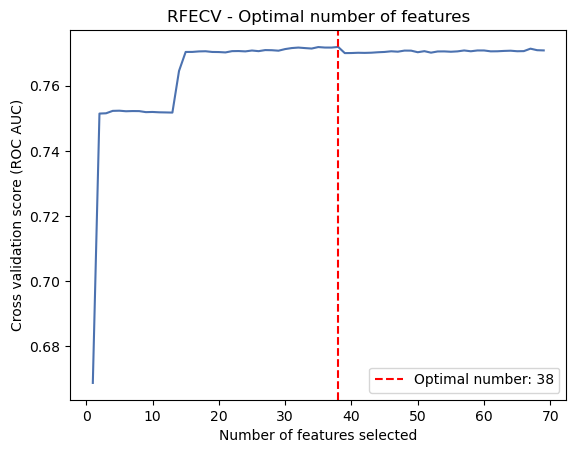

In [11]:
plt.figure()
# Get the cross-validation scores
min_features_to_select = 1  
n_scores = len(rfecv.cv_results_['mean_test_score'])
plt.plot(range(min_features_to_select, n_scores + min_features_to_select), 
         rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
# add the optimal number of features line
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
            label=f'Optimal number: {rfecv.n_features_}')
plt.legend()
plt.title("RFECV - Optimal number of features")
plt.savefig('./plots/RFECV.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
selected_feature_names = list(newX.columns[rfecv.support_])
print(f"{rfecv.n_features_} selected feature names: {selected_feature_names}")

# Show all features with their rankings
feature_ranking_df = pd.DataFrame({
    'feature': newX.columns,
    'ranking': rfecv.ranking_
}).sort_values('ranking')
print("\nFeature rankings:")
with pd.option_context('display.max_rows', None):
    print(feature_ranking_df)

38 selected feature names: ['fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'fulladdress_count_0_by_7', 'address_count_1', 'fulladdress_count_1', 'ssn_dob_count_30', 'ssn_count_30', 'ssn_ssn_count_30', 'ssn_firstname_count_30', 'ssn_lastname_count_30', 'fulladdress_homephone_count_30', 'ssn_name_dob_count_30', 'name_dob_count_30', 'ssn_name_count_30', 'ssn_ssn_count_14', 'ssn_count_14', 'ssn_dob_count_14', 'ssn_firstname_count_14', 'zip5_count_1', 'ssn_lastname_count_14', 'zip5_count_3', 'name_dob_count_14', 'ssn_name_count_14', 'ssn_name_dob_count_14', 'ssn_name_dob_count_0_by_30', 'fulladdress_count_1_by_14', 'fulladdress_homephone_count_7', 'fulladdress_homephone_count_0_by_30', 'ssn_dob_count_0_by_14', 'ssn_ssn_count_0_by_30', 'ssn_firstname_count_0_by_14', 'ssn_ssn_count_7', 'ssn_lastname_count_0_by_30', 'ssn_name_count_0_by_30', 'name_dob_count_0_by_30']

Feature rankings:
                                feature  ranki

In [13]:
del newX, y

In [14]:
final_cut = pd.read_csv('./data/vars 485.csv', index_col=0)
final_cut = final_cut[selected_feature_names + ['fraud_label']]
final_cut.to_csv('./data/selected.csv')

# Standardization

In [2]:
#final_cut = pd.read_csv('./data/vars 485.csv', index_col=0)

In [15]:
label = final_cut.fraud_label
label.shape

(981694,)

In [16]:
only_feature = final_cut.drop(['fraud_label'], axis=1)
print('features shape: ', only_feature.shape)
std = only_feature.std()
mean = only_feature.mean()
z_scaled = (only_feature - mean)/std
del final_cut
# Prevent extreme values after z-scaled
z_scaled = z_scaled.clip(lower=-1000, upper=1000)
z_scaled.describe()

features shape:  (981694, 38)


,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,fulladdress_count_0_by_7,address_count_1,fulladdress_count_1,ssn_dob_count_30,ssn_count_30,...,fulladdress_count_1_by_14,fulladdress_homephone_count_7,fulladdress_homephone_count_0_by_30,ssn_dob_count_0_by_14,ssn_ssn_count_0_by_30,ssn_firstname_count_0_by_14,ssn_ssn_count_7,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,name_dob_count_0_by_30
count,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,...,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05,9.816940e+05
mean,-1.779950e-16,1.749262e-16,-1.817588e-16,4.771240e-17,-9.779884e-17,-9.361445e-15,-1.314986e-16,-1.035892e-16,1.580473e-16,-7.711285e-17,...,-8.919982e-16,-5.686114e-17,-2.698096e-15,2.757297e-15,3.116708e-15,3.251216e-15,1.832064e-16,-1.086528e-15,-6.886741e-16,8.410469e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.014801e-01,-8.811756e-02,-7.861317e-02,-7.224399e-02,-6.669609e-02,-1.608808e+01,-5.052480e-02,-4.911750e-02,-9.749015e-02,-9.898774e-02,...,-1.445355e+01,-5.738306e-02,-1.060622e+01,-1.424818e+01,-1.038727e+01,-1.419962e+01,-5.756734e-02,-1.053985e+01,-1.055863e+01,-1.028042e+01
25%,-1.014801e-01,-8.811756e-02,-7.861317e-02,-7.224399e-02,-6.669609e-02,1.027352e-01,-5.052480e-02,-4.911750e-02,-9.749015e-02,-9.898774e-02,...,1.242213e-01,-5.738306e-02,1.717972e-01,1.240919e-01,1.744921e-01,1.246376e-01,-5.756734e-02,1.730347e-01,1.727000e-01,1.771260e-01
50%,-1.014801e-01,-8.811756e-02,-7.861317e-02,-7.224399e-02,-6.669609e-02,1.027352e-01,-5.052480e-02,-4.911750e-02,-9.749015e-02,-9.898774e-02,...,1.242213e-01,-5.738306e-02,1.717972e-01,1.240919e-01,1.744921e-01,1.246376e-01,-5.756734e-02,1.730347e-01,1.727000e-01,1.771260e-01
75%,-1.014801e-01,-8.811756e-02,-7.861317e-02,-7.224399e-02,-6.669609e-02,1.027352e-01,-5.052480e-02,-4.911750e-02,-9.749015e-02,-9.898774e-02,...,1.242213e-01,-5.738306e-02,1.717972e-01,1.240919e-01,1.744921e-01,1.246376e-01,-5.756734e-02,1.730347e-01,1.727000e-01,1.771260e-01
max,4.534025e+01,4.648183e+01,4.733666e+01,4.903885e+01,4.942450e+01,1.027352e-01,5.951043e+01,5.960670e+01,6.560285e+01,6.375091e+01,...,1.242213e-01,6.258480e+01,1.717972e-01,1.240919e-01,1.744921e-01,1.246376e-01,7.214321e+01,1.730347e-01,1.727000e-01,1.771260e-01


In [17]:
z_scaled['fraud_label']=label
z_scaled.to_csv('./data/z_scaled.csv')

# Feature Reduction

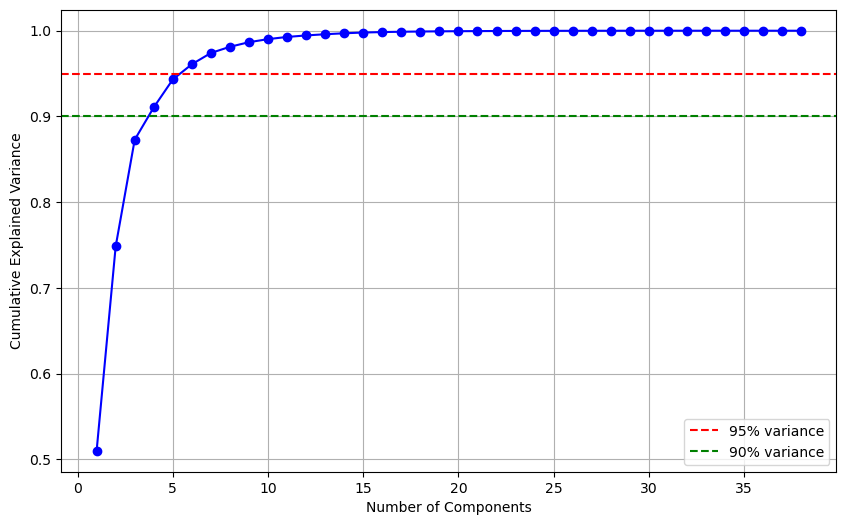

Components for 95% variance: 5
Components for 90% variance: 3


In [18]:
from sklearn.decomposition import PCA

X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
# Fit PCA with all components
pca = PCA()
pca.fit(X)
# Calculate cumulative variance explained
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid(True)
plt.show()
# Find number of components for desired variance
n_components_95 = round(np.argmax(cumsum_var >= 0.95))
n_components_90 = round(np.argmax(cumsum_var >= 0.90))
print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 90% variance: {n_components_90}")

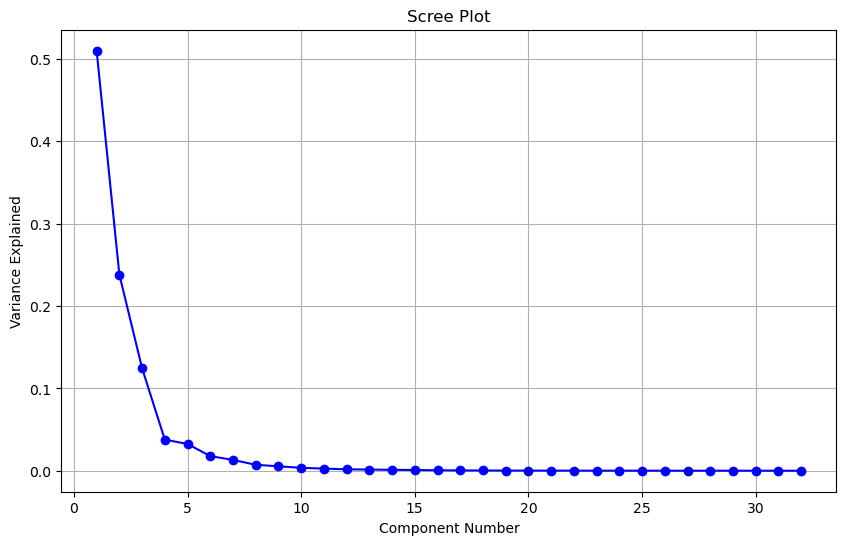

In [19]:
# Plot individual variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, 33), pca.explained_variance_ratio_[:32], 'bo-')
plt.xlabel('Component Number')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

split statistics to about 80% train, test set (X, y will be divided by train_test_split function) and 20% Out Of Time (OOT)

In [20]:
total = X.shape[0]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_components=3, AUC=0.7651 (+/- 0.0043)
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 4

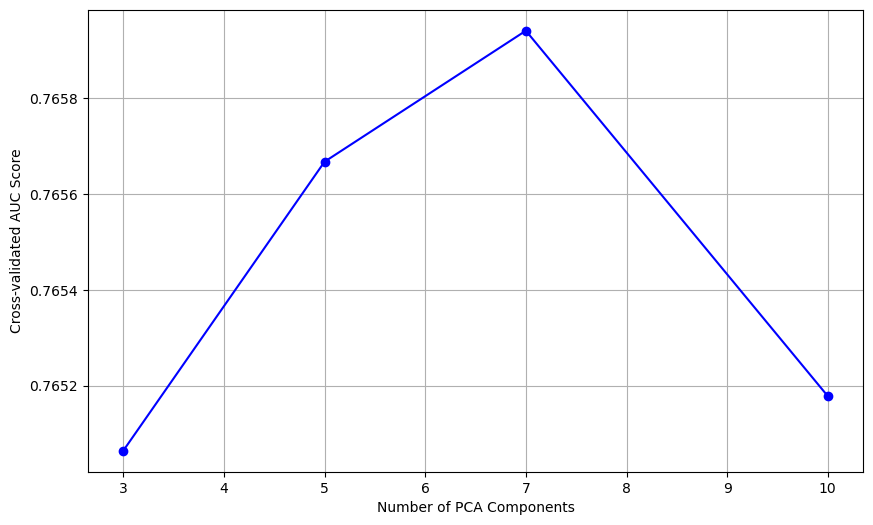

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Test different numbers of components
n_components_range = [3, 5, 7, 10]
cv_scores = []

for n in n_components_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    cv_scores.append(scores.mean())
    print(f"n_components={n}, AUC={scores.mean():.4f} (+/- {scores.std():.4f})")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cv_scores, 'bo-')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cross-validated AUC Score')
plt.grid(True)
plt.show()

In [22]:
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label

# Apply PCA with 5 components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
pca_columns = [f'PC{i+1}' for i in range(5)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['fraud'] = y
df_pca.to_csv('./data/reduced_pca.csv')

# 🔍 Summary of Insights

- **Entity-Centric Features**  
  - Generated features by cross-linking key identity attributes (e.g., `ssn`, `dob`, `address`, `phone`, `name`)  
  - Calculated frequency-based features across multiple rolling time windows (0, 1, 3, 7, 14, 30 days)  
  - Introduced `*_day_since` features to capture recency of related activity

- **Temporal Risk Signals**  
  - Extracted day-of-week (`dow`) and mapped it to smoothed fraud rates (`dow_risk`)  
  - Captured cyclical fraud behavior patterns while mitigating data sparsity

- **Composite Identity Construction**  
  - Created compound identifiers (e.g., `name_dob`, `name_fulladdress`, `ssn_name_homephone`)  
  - Enhanced fraud signal strength by modeling identity reuse and synthetic combinations

- **Efficient Large-Scale Processing**  
  - Applied chunked processing and DuckDB SQL pipelines for fast, scalable computation  
  - Reduced memory usage and execution time when engineering features for ~1 million records

- **Feature Selection and Ranking**  
  - Used KS statistics and Fraud Detection Rate (FDR) to rank 485+ features  
  - Selected top 70 based on average ranking, then applied RFECV to retain **38 optimal features**  
  - Features were selected for both predictive power and interpretability

- **Dimensionality Reduction & Model Readiness**  
  - PCA showed that **5 components explained >95% of variance**, with stable AUC across 3–10 components  
  - Random Forest + PCA cross-validation yielded AUC ≈ **0.766**, confirming robustness of engineered features